In [64]:
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import matplotlib.gridspec as gridspec

from matplotlib.table import Table
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import OrderedDict
from scipy.interpolate import griddata
from torch import nn, optim

import warnings
warnings.filterwarnings('ignore')

SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.set_default_tensor_type(torch.FloatTensor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
class DNN(nn.Module):
    
    def __init__(self, layers):
        super().__init__()
        
        self.depth = len(layers) - 1
        self.activation = nn.Tanh
        layer_list = []

        for i in range(self.depth - 1):
            layer_list.extend([
                (f'layer_{i}', nn.Linear(layers[i], layers[i+1])),
                (f'activation_{i}', self.activation())
            ])
            
        layer_list.append((f'layer_{self.depth - 1}', nn.Linear(layers[-2], layers[-1])))
        layer_dict = OrderedDict(layer_list)
        self.layers = nn.Sequential(layer_dict)
        
    def forward(self, x):
        return self.layers(x)

In [12]:
class TorchPINN:
    
    def __init__(self, X, u, layers, lb, ub, device):
        
        self.device = device
        
        self.lb = torch.tensor(lb, dtype=torch.float32, device=device)
        self.ub = torch.tensor(ub, dtype=torch.float32, device=device)
        
        self.x = torch.tensor(X[:, 0:1], requires_grad=True, dtype=torch.float32, device=device)
        self.t = torch.tensor(X[:, 1:2], requires_grad=True, dtype=torch.float32, device=device)
        self.u = torch.tensor(u, dtype=torch.float32, device=device)
        
        self.lambda_1 = nn.Parameter(torch.tensor([0.0], device=device))
        self.lambda_2 = nn.Parameter(torch.tensor([-6.0], device=device))
        
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        self.dnn.register_parameter('lambda_2', self.lambda_2)

        self.optimizer = optim.LBFGS(
            self.dnn.parameters(),
            lr=1.0,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )
        
        self.optimizer_Adam = optim.Adam(self.dnn.parameters())
        self.iter = 0
        
        self.u_loss_history = []
        self.f_loss_history = []
        self.lambda_1_history = []
        self.lambda_2_history = []
        
    def net_u(self, x, t):
        return self.dnn(torch.cat([x, t], dim=1))
    
    def net_f(self, x, t):
        lambda_1 = self.lambda_1
        lambda_2 = torch.exp(self.lambda_2)
        u = self.net_u(x, t)

        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f
    
    def loss_func(self):
        
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)
        
        u_loss = torch.mean((self.u - u_pred) ** 2)
        f_loss = torch.mean(f_pred ** 2)
        
        loss = u_loss + f_loss
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        
        if self.iter % 100 == 0:
            print(f'Loss: {loss.item():.1e}, l1: {self.lambda_1.item():.5f}, l2: {torch.exp(self.lambda_2.detach()).item():.5f}')
            
        self.u_loss_history.append(u_loss.item())
        self.f_loss_history.append(f_loss.item())
        self.lambda_1_history.append(self.lambda_1.item())
        self.lambda_2_history.append(torch.exp(self.lambda_2).item())
        
        return loss
    
    def train(self, epochs):
        
        self.dnn.train()
        
        self.u_loss_history = []
        self.f_loss_history = []
        self.lambda_1_history = []
        self.lambda_2_history = []
        
        for epoch in range(epochs):
            
            u_pred = self.net_u(self.x, self.t)
            f_pred = self.net_f(self.x, self.t)
            
            u_loss = torch.mean((self.u - u_pred) ** 2)
            f_loss = torch.mean(f_pred ** 2)
            
            loss = u_loss + f_loss
            
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 100 == 0:
                print(f'Iter: {epoch}, Loss: {loss.item():.1e}, Lambda_1: {self.lambda_1.item():.3f}, Lambda_2: {torch.exp(self.lambda_2).item():.6f}')
            
            self.u_loss_history.append(u_loss.item())
            self.f_loss_history.append(f_loss.item())
            self.lambda_1_history.append(self.lambda_1.item())
            self.lambda_2_history.append(torch.exp(self.lambda_2).item())
            
        self.optimizer.step(self.loss_func)
    
    def predict(self, X):
        
        x = torch.tensor(X[:, 0:1], requires_grad=True, dtype=torch.float32, device=self.device)
        t = torch.tensor(X[:, 1:2], requires_grad=True, dtype=torch.float32, device=self.device)

        self.dnn.eval()
        
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        
        return u, f

In [13]:
nu = 0.01 / np.pi

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('../data/burgers_shock.mat')

t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

# Domain bounds
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)

In [14]:
noise = 0.0

# Create training set
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx, :]

# Training
model = TorchPINN(X_u_train, u_train, layers, lb, ub, device)
model.train(0)

Loss: 2.8e-02, l1: 0.13585, l2: 0.00190
Loss: 1.9e-02, l1: 0.40511, l2: 0.00370
Loss: 9.8e-03, l1: 0.72686, l2: 0.00606
Loss: 5.1e-03, l1: 0.81886, l2: 0.00732
Loss: 2.9e-03, l1: 0.89164, l2: 0.00729
Loss: 1.7e-03, l1: 0.93047, l2: 0.00642
Loss: 1.0e-03, l1: 0.96572, l2: 0.00594
Loss: 6.5e-04, l1: 0.95989, l2: 0.00514
Loss: 4.4e-04, l1: 0.97429, l2: 0.00430
Loss: 3.1e-04, l1: 0.99514, l2: 0.00406
Loss: 2.3e-04, l1: 0.98767, l2: 0.00381
Loss: 1.7e-04, l1: 0.99219, l2: 0.00361
Loss: 1.2e-04, l1: 1.00141, l2: 0.00353
Loss: 1.0e-04, l1: 0.99606, l2: 0.00353
Loss: 9.0e-05, l1: 0.99835, l2: 0.00348
Loss: 8.0e-05, l1: 0.99616, l2: 0.00346
Loss: 7.1e-05, l1: 0.99792, l2: 0.00343
Loss: 6.5e-05, l1: 0.99745, l2: 0.00341
Loss: 6.0e-05, l1: 0.99738, l2: 0.00340
Loss: 5.3e-05, l1: 0.99585, l2: 0.00337
Loss: 4.6e-05, l1: 0.99690, l2: 0.00335
Loss: 4.0e-05, l1: 0.99682, l2: 0.00335
Loss: 3.6e-05, l1: 0.99671, l2: 0.00335
Loss: 3.2e-05, l1: 0.99934, l2: 0.00336
Loss: 2.9e-05, l1: 1.00006, l2: 0.00336


In [15]:
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.lambda_1.detach().cpu().numpy()
lambda_2_value = model.lambda_2.detach().cpu().numpy()
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print(f'Error u: {error_u:.1e}')
print(f'Error l1: {error_lambda_1.item():.5f}%')
print(f'Error l2: {error_lambda_2.item():.5f}%')


Error u: 1.8e-03
Error l1: 0.05540%
Error l2: 0.53574%


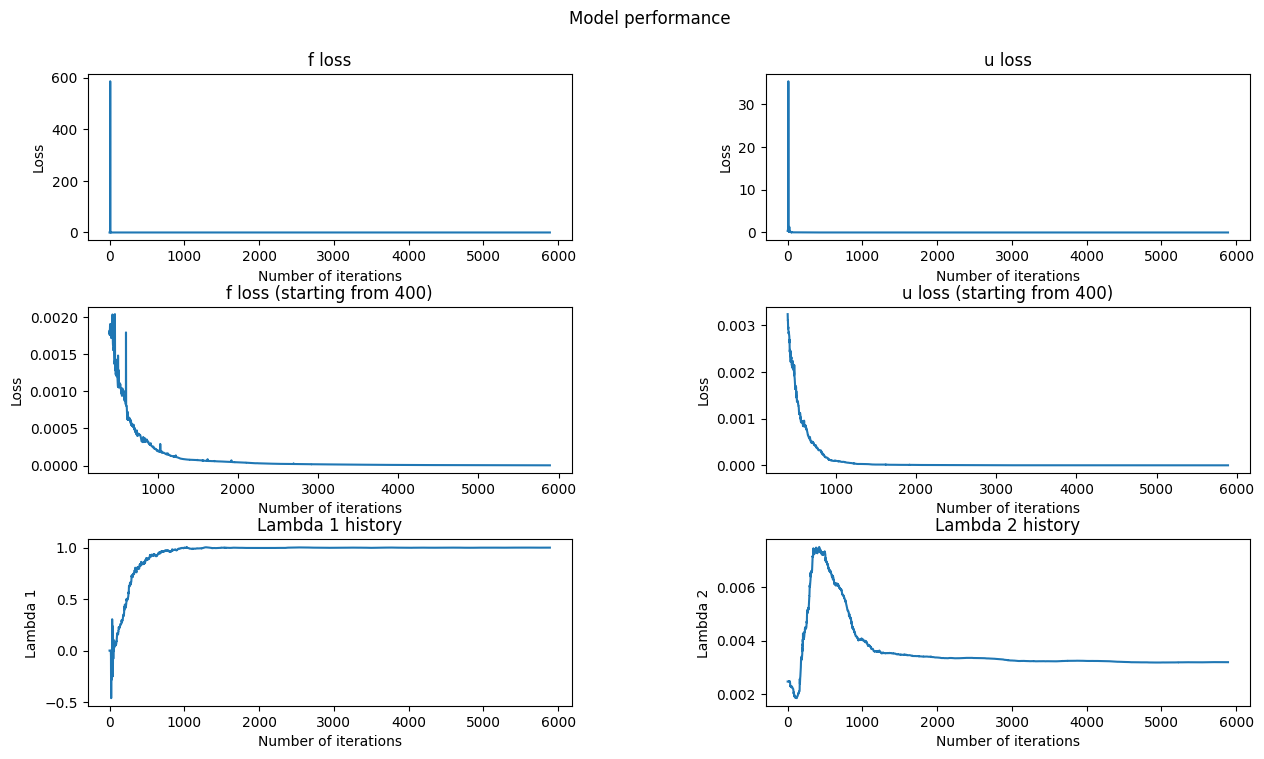

In [30]:
skip_size = 400
fig, axs = plt.subplots(3, 2, figsize=(15, 8))
fig.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)

axs[0,0].plot(np.linspace(0, len(model.f_loss_history), len(model.f_loss_history)), model.f_loss_history, label="f loss")
axs[0,0].set_xlabel('Number of iterations')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title("f loss")
# axs[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[0,1].plot(np.linspace(0, len(model.u_loss_history), len(model.u_loss_history)), model.u_loss_history, label="u loss")
axs[0,1].set_xlabel('Number of iterations')
axs[0,1].set_ylabel('Loss')
axs[0,1].set_title("u loss")
# axs[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[1,0].plot(np.linspace(0, len(model.f_loss_history), len(model.f_loss_history))[skip_size:], model.f_loss_history[skip_size:], label="f loss")
axs[1,0].set_xlabel('Number of iterations')
axs[1,0].set_ylabel('Loss')
axs[1,0].set_title(f"f loss (starting from {skip_size})")
# axs[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[1,1].plot(np.linspace(0, len(model.u_loss_history), len(model.u_loss_history))[skip_size:], model.u_loss_history[skip_size:], label="u loss")
axs[1,1].set_xlabel('Number of iterations')
axs[1,1].set_ylabel('Loss')
axs[1,1].set_title(f"u loss (starting from {skip_size})")
# axs[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[2,0].plot(np.linspace(0, len(model.lambda_1_history), len(model.lambda_1_history)), model.lambda_1_history, label="lambda 1")
axs[2,0].set_xlabel('Number of iterations')
axs[2,0].set_ylabel('Lambda 1')
axs[2,0].set_title("Lambda 1 history")
# axs[0,2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[2,1].plot(np.linspace(0, len(model.lambda_2_history), len(model.lambda_2_history)), model.lambda_2_history, label="lambda 2")
axs[2,1].set_xlabel('Number of iterations')
axs[2,1].set_ylabel('Lambda 2')
axs[2,1].set_title("Lambda 2 history")
# axs[1,0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Model performance")
plt.show()

In [31]:
noise = 0.01

# Create training set with noise
u_train = u_train + noise * np.std(u_train) * np.random.randn(u_train.shape[0], u_train.shape[1])

# Training with noisy data
model = TorchPINN(X_u_train, u_train, layers, lb, ub, device)
model.train(10000)

Iter: 0, Loss: 4.0e-01, Lambda_1: -0.001, Lambda_2: 0.002480
Iter: 100, Loss: 8.6e-02, Lambda_1: -0.009, Lambda_2: 0.002447
Iter: 200, Loss: 3.3e-02, Lambda_1: 0.063, Lambda_2: 0.002260
Iter: 300, Loss: 2.8e-02, Lambda_1: 0.099, Lambda_2: 0.002266
Iter: 400, Loss: 2.4e-02, Lambda_1: 0.150, Lambda_2: 0.002247
Iter: 500, Loss: 2.3e-02, Lambda_1: 0.195, Lambda_2: 0.002276
Iter: 600, Loss: 2.2e-02, Lambda_1: 0.227, Lambda_2: 0.002355
Iter: 700, Loss: 2.1e-02, Lambda_1: 0.258, Lambda_2: 0.002450
Iter: 800, Loss: 1.8e-02, Lambda_1: 0.298, Lambda_2: 0.002536
Iter: 900, Loss: 2.1e-02, Lambda_1: 0.348, Lambda_2: 0.002640
Iter: 1000, Loss: 1.5e-02, Lambda_1: 0.388, Lambda_2: 0.002807
Iter: 1100, Loss: 1.2e-02, Lambda_1: 0.442, Lambda_2: 0.002966
Iter: 1200, Loss: 1.0e-02, Lambda_1: 0.498, Lambda_2: 0.003080
Iter: 1300, Loss: 9.4e-03, Lambda_1: 0.537, Lambda_2: 0.003162
Iter: 1400, Loss: 8.6e-03, Lambda_1: 0.564, Lambda_2: 0.003242
Iter: 1500, Loss: 8.3e-03, Lambda_1: 0.586, Lambda_2: 0.003303
It

In [32]:
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.lambda_1.detach().cpu().numpy()
lambda_2_value = model.lambda_2.detach().cpu().numpy()
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print(f'Error u: {error_u:.1e}')
print(f'Error l1: {error_lambda_1.item():.5f}%')
print(f'Error l2: {error_lambda_2.item():.5f}%')

Error u: 2.1e-03
Error l1: 0.10234%
Error l2: 0.90808%


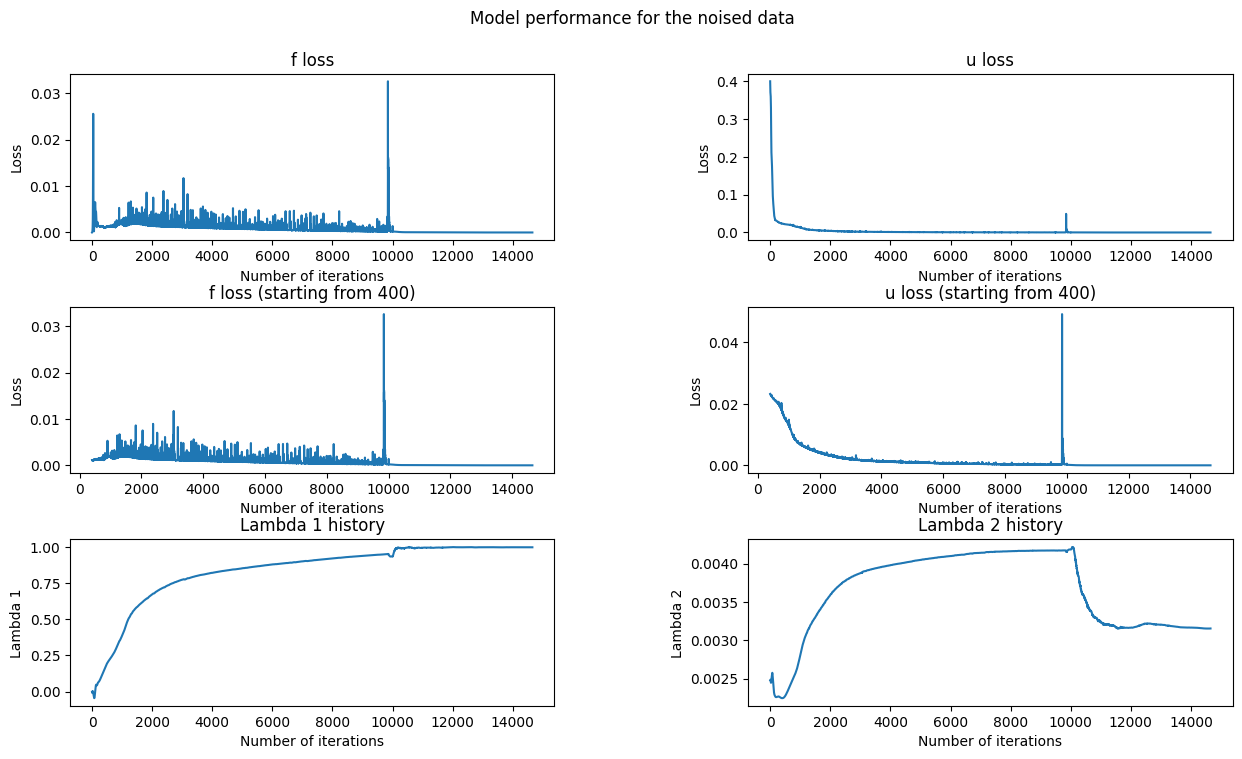

In [34]:
skip_size = 400
fig, axs = plt.subplots(3, 2, figsize=(15, 8))
fig.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)

axs[0,0].plot(np.linspace(0, len(model.f_loss_history), len(model.f_loss_history)), model.f_loss_history, label="f loss")
axs[0,0].set_xlabel('Number of iterations')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title("f loss")
# axs[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[0,1].plot(np.linspace(0, len(model.u_loss_history), len(model.u_loss_history)), model.u_loss_history, label="u loss")
axs[0,1].set_xlabel('Number of iterations')
axs[0,1].set_ylabel('Loss')
axs[0,1].set_title("u loss")
# axs[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[1,0].plot(np.linspace(0, len(model.f_loss_history), len(model.f_loss_history))[skip_size:], model.f_loss_history[skip_size:], label="f loss")
axs[1,0].set_xlabel('Number of iterations')
axs[1,0].set_ylabel('Loss')
axs[1,0].set_title(f"f loss (starting from {skip_size})")
# axs[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[1,1].plot(np.linspace(0, len(model.u_loss_history), len(model.u_loss_history))[skip_size:], model.u_loss_history[skip_size:], label="u loss")
axs[1,1].set_xlabel('Number of iterations')
axs[1,1].set_ylabel('Loss')
axs[1,1].set_title(f"u loss (starting from {skip_size})")
# axs[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[2,0].plot(np.linspace(0, len(model.lambda_1_history), len(model.lambda_1_history)), model.lambda_1_history, label="lambda 1")
axs[2,0].set_xlabel('Number of iterations')
axs[2,0].set_ylabel('Lambda 1')
axs[2,0].set_title("Lambda 1 history")
# axs[0,2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[2,1].plot(np.linspace(0, len(model.lambda_2_history), len(model.lambda_2_history)), model.lambda_2_history, label="lambda 2")
axs[2,1].set_xlabel('Number of iterations')
axs[2,1].set_ylabel('Lambda 2')
axs[2,1].set_title("Lambda 2 history")
# axs[1,0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Model performance for the noised data")
plt.show()

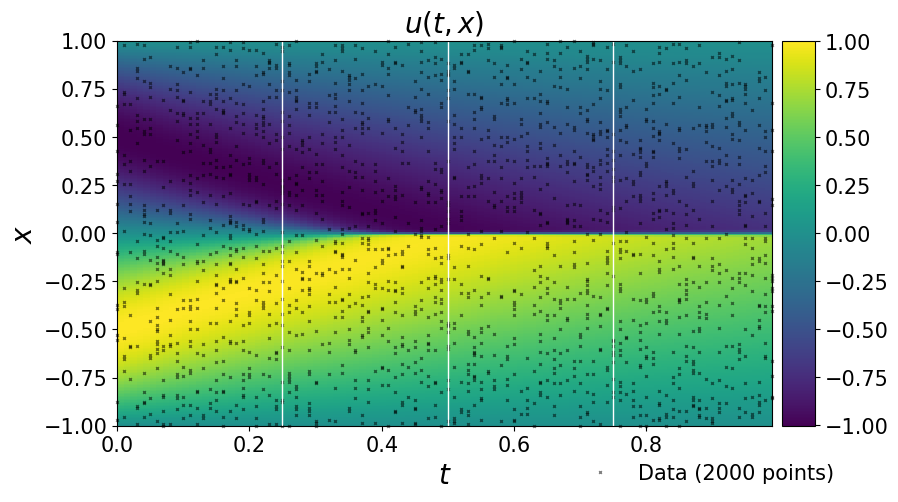

In [35]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    X_u_train[:, 1],
    X_u_train[:, 0],
    'kx', label=f'Data ({u_train.shape[0]} points)',
    markersize=2,
    clip_on=False,
    alpha=.5
)

line = np.linspace(x.min(), x.max(), 2)[:, None]
ax.plot(t[25] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[50] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[75] * np.ones((2, 1)), line, 'w-', linewidth=1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.9, -0.05),
    ncol=5,
    frameon=False,
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize=20)
ax.tick_params(labelsize=15)

plt.show()


In [42]:
np.linspace(0, 1, 6)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

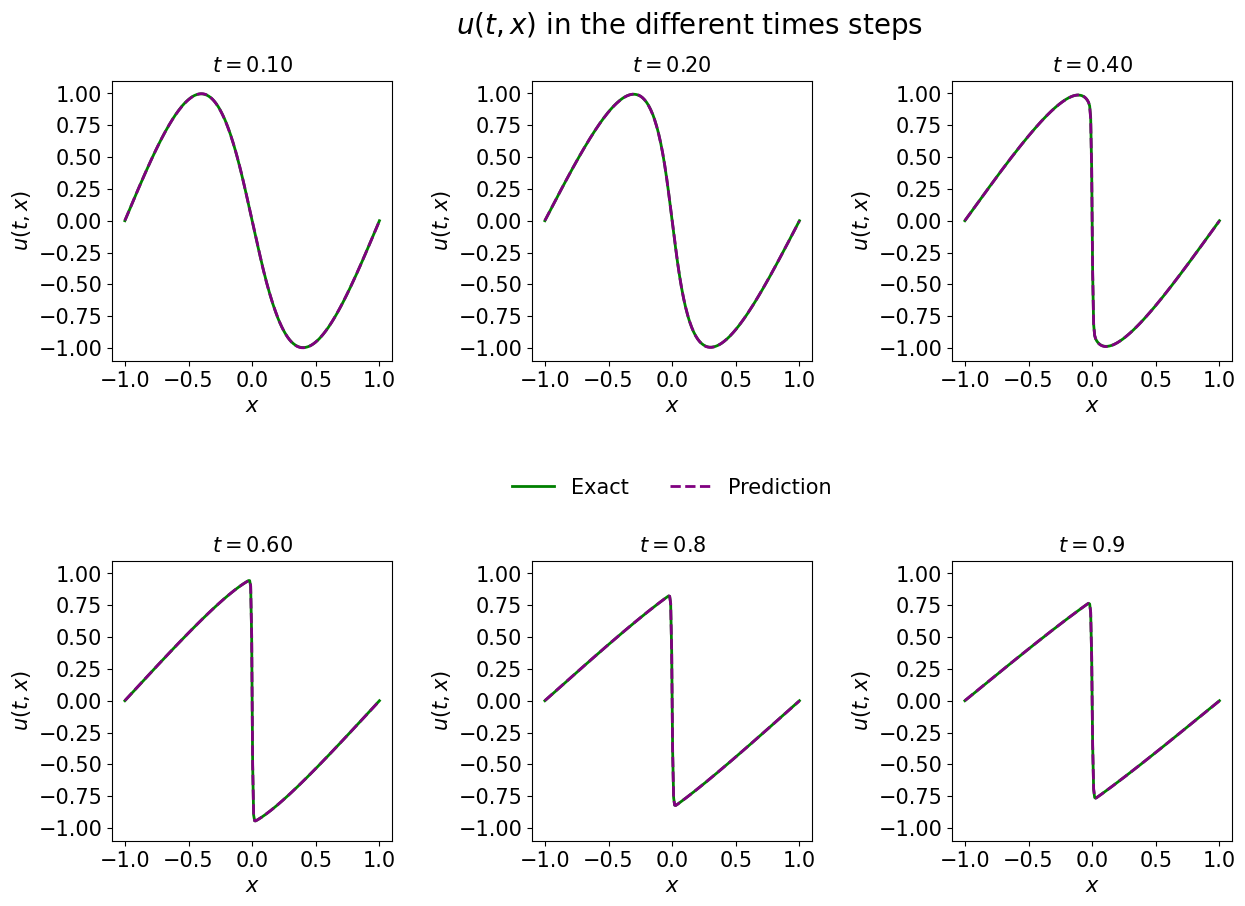

In [69]:
fig = plt.figure(figsize=(14, 10))

gs1 = gridspec.GridSpec(2, 3)
gs1.update(top=1 - 0.1, bottom=0.1, left=0.1, right=0.9, wspace=0.5, hspace=0.5)

t_values = [10, 20, 40, 60, 80, 90]
titles = ['$t = 0.10$', '$t = 0.20$', '$t = 0.40$', '$t = 0.60$', '$t = 0.8$', '$t = 0.9$']

for i in range(6):
    row = i // 3
    col = i % 3
    ax = plt.subplot(gs1[row, col])
    ax.plot(x, Exact[t_values[i], :], 'b-', linewidth=2, label='Exact', color="green")
    ax.plot(x, U_pred[t_values[i], :], 'r--', linewidth=2, label='Prediction', color="purple")
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.set_title(titles[i], fontsize=15)

    if i == 1:
        ax.legend(
            loc='upper center',
            bbox_to_anchor=(0.5, -0.35),
            ncol=5,
            frameon=False,
            prop={'size': 15}
        )

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

big_title_ax = fig.add_subplot(111, frame_on=False)
big_title_ax.set_axis_off()
big_title_ax.set_title('$u(t,x)$ in the different times steps', fontsize=20, y=1.05)

plt.show()

In [55]:
u_pred, f_pred = model.predict(X_star)

lambda_1_value_noisy = model.lambda_1.detach().cpu().numpy()
lambda_2_value_noisy = model.lambda_2.detach().cpu().numpy()
lambda_2_value_noisy = np.exp(lambda_2_value_noisy)

error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0) * 100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - nu) / nu * 100

print(f'Error u: {error_u:.1e}')
print(f'Error l1: {error_lambda_1_noisy.item():.5f}%')
print(f'Error l2: {error_lambda_2_noisy.item():.5f}%')

Error u: 2.142590e-03
Error l1: 0.10234%
Error l2: 0.90808%


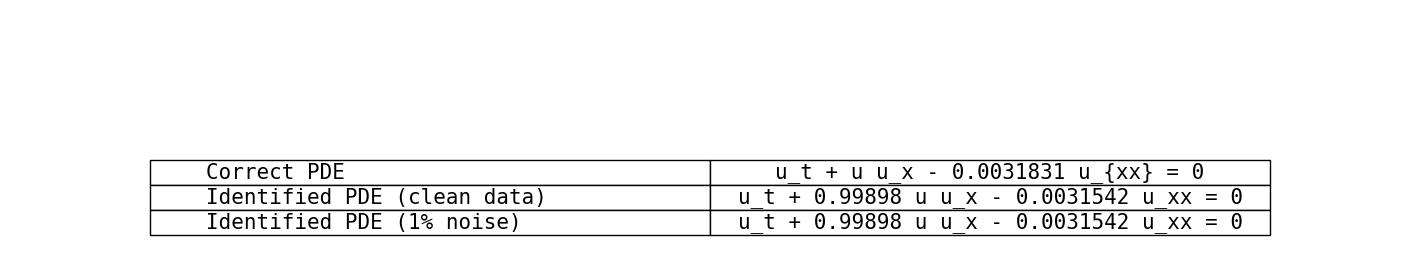

In [63]:
fig = plt.figure(figsize=(14, 10))

gs2 = gridspec.GridSpec(1, 1)
gs2.update(top=0.25, bottom=0, left=0.0, right=1.0, wspace=0.0)

ax = plt.subplot(gs2[:, :])
ax.axis('off')

xx = 'xx'

# Table data
table_data = [
    ['Correct PDE', 'u_t + u u_x - 0.0031831 u_{xx} = 0'],
    ['Identified PDE (clean data)', f'u_t + {lambda_1_value.item():.5f} u u_x - {lambda_2_value.item():.7f} u_{xx} = 0'],
    ['Identified PDE (1% noise)', f'u_t + {lambda_1_value_noisy.item():.5f} u u_x - {lambda_2_value_noisy.item():.7f} u_{xx} = 0'],
]

# Draw the table
table = Table(ax, bbox=[0.1, 0.1, 0.8, 0.3])

# Add cells to the table
for i, row in enumerate(table_data):
    for j, cell_text in enumerate(row):
        table.add_cell(i, j, width=0.9, height=0.8,
                       text=cell_text, loc='left' if j == 0 else 'center',
                       fontproperties={'size': 18, 'family': 'monospace'})

# Set column and row labels
table.auto_set_font_size(False)
table.set_fontsize(15)
table.scale(1, 2.5)

# Add table to the figure
ax.add_table(table)


In [51]:
# Save the model
torch.save(model, "burgers_torch_model.pt")